In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, train_test_split
url_csv = 'https://raw.githubusercontent.com/CausalML/TreatmentEffectRisk/main/data/behaghel.csv'
import warnings
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

warnings.filterwarnings('ignore')

In [2]:
original_result = pd.read_csv("../data/results.csv")

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# Cargar los datos
job = pd.read_csv(url_csv)

# Definir las variables categóricas (binarias) y numéricas
Xbin = [
    'College_education', 'nivetude2', 'Vocational', 'High_school_dropout', 
    'Manager', 'Technician', 'Skilled_clerical_worker', 'Unskilled_clerical_worker', 
    'Skilled_blue_colar', 'Unskilled_blue_colar', 'Woman', 'Married', 'French', 
    'African', 'Other_Nationality', 'Paris_region', 'North', 'Other_regions', 
    'Employment_component_level_1', 'Employment_component_level_2', 
    'Employment_component_missing', 'Economic_Layoff', 'Personnal_Layoff', 
    'End_of_Fixed_Term_Contract', 'End_of_Temporary_Work', 'Other_reasons_of_unemployment', 
    'Statistical_risk_level_2', 'Statistical_risk_level_3', 'Other_Statistical_risk', 
    'Search_for_a_full_time_position', 'Sensitive_suburban_area', 'Insertion', 
    'Interim', 'Conseil'
]

Xnum = [
    'age', 'Number_of_children', 'exper', 'salaire.num', 'mois_saisie_occ', 'ndem'
]

Xall = Xbin + Xnum

# Filtrar y transformar los datos
job_binary = job[(job['A_public'] == 1) | (job['A_private'] == 1)].copy()
job_binary['sw'] = job_binary['sw'] / job_binary['sw'].mean()
job_binary['A'] = job_binary['A_public']
job_binary['ipw'] = 1 / (
    job_binary['A_standard'] * job_binary['sw'] * job_binary['A_standard'].mean() + 
    job_binary['A_private'] * job_binary['sw'] * job_binary['A_private'].mean() + 
    job_binary['A_public'] * job_binary['sw'] * job_binary['A_public'].mean()
)


In [4]:
from utils import make_cvgroup_balanced
from models import tau_predict, mu_calculate, var_calculate

In [5]:

np.random.seed(0)
K = 5
cvgroup = make_cvgroup_balanced(job_binary, K, 'A')


In [6]:

job_binary['y_ref'] = (2 * job_binary['A'] - 1) * job_binary['ipw'] * job_binary['Y']

# X and y for the model
X = job_binary[Xall]  # Assuming Xall is a list of column names
y = job_binary['y_ref']

tau_pred = tau_predict(X, y, job_binary['sw'])



In [7]:
bad_c = ['age','Paris_region','African','High_school_dropout']
Xbad = job_binary[bad_c]
tau_pred_bad = tau_predict(Xbad, y, job_binary['sw'])

In [8]:

y = job_binary['Y']
X = job_binary[Xall]
mu0, mu1 = mu_calculate(
    job_binary, cvgroup, y, X 
)

In [9]:
job_binary['mu0'] = mu0
job_binary['mu1'] = mu1
var0, var1 = var_calculate(job_binary, job_binary[Xall], cvgroup)
job_binary['var0'] = var0
job_binary['var1'] = var1
job_binary['tau'] = tau_pred
job_binary['tau_bad'] = tau_pred_bad

# Plots

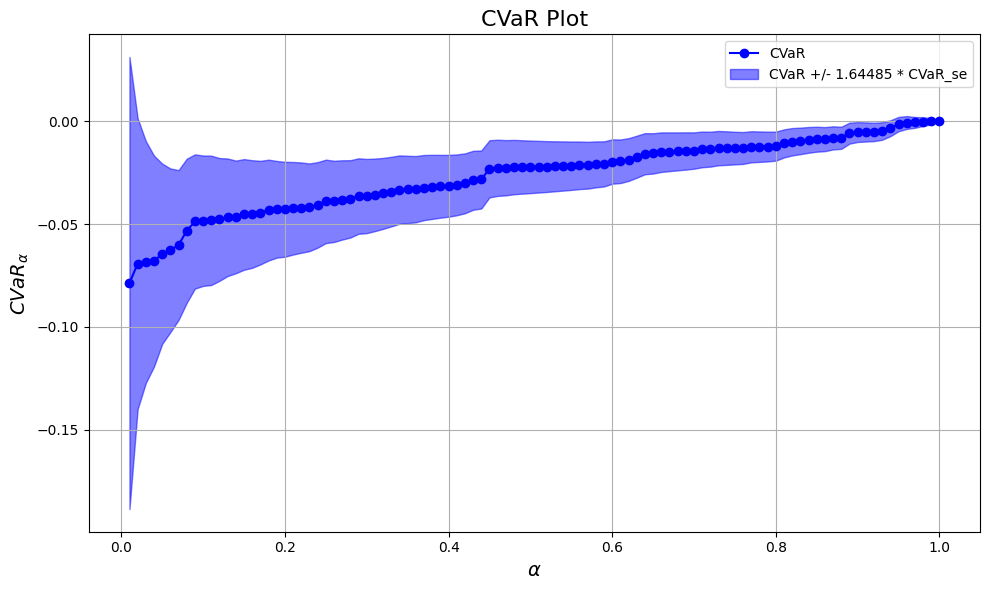

In [10]:
from CVaR_calculate import cvar_calculate, cvar_if_plugin, cvar_if_tauate, cvar_bbound_mate
from plots import plot_cvar
ps = np.arange(0.01, 1.01, 0.01)

# Crear un DataFrame vacío para almacenar los resultados
CVaR = pd.DataFrame(columns=['CVaR', 'CVaR_se', 'p'])

# Iterar sobre cada valor en ps y calcular CVaR usando cvar_calculate
for x in ps:
    result = cvar_calculate(job_binary, x, tau='tau', method_if=cvar_if_tauate)
    CVaR = pd.concat([CVaR, result], ignore_index=True)

plot_cvar(CVaR, rearrangement=True)

# Groups

In [12]:
from utils import wtdquantile
from joblib import Parallel, delayed

ipw = job_binary['ipw']
bs = np.arange(0, 0.30, 0.05)


In [13]:
CVaRmate = pd.DataFrame()
for p in ps:
    for b in bs:
        result = cvar_calculate(job_binary, p, b=b, tau='tau', method_if=cvar_bbound_mate)
        CVaRmate = pd.concat([CVaRmate, result], ignore_index=True)

In [14]:
CVaRmate.CVaR.min()

np.float64(-0.07865874745221509)

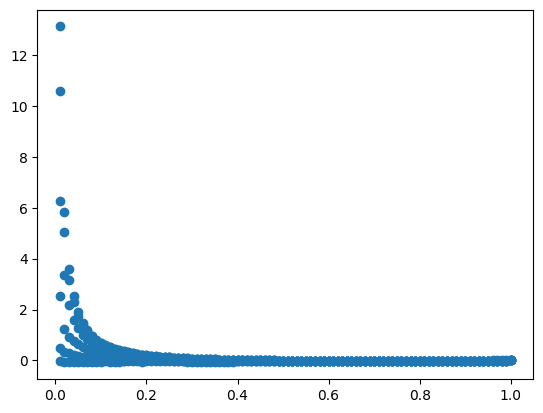

In [15]:
import matplotlib.pyplot as plt
plt.scatter('p', "CVaR", data = CVaRmate)

In [57]:
results = Parallel(n_jobs=-1)(delayed(calculate_CVaR)(p, b, job_binary, mu1, mu0, ipw) for p in ps for b in bs)
CVaR_bbound_mATE = pd.concat(results).reset_index(drop=True).sort_values("p")

In [21]:
mu0 = original_result['mu0']
mu1 = original_result['mu1']
ipw = original_result['ipw']
# Mate
def calculate_CVaR(p, b, df, mu1, mu0, ipw):
    data = df.copy()
    b1 = np.concatenate((data['tau'] + b, data['tau'] - b))
    c1 = np.concatenate((data['sw'], data['sw']))
    q = wtdquantile(b1, c1, p)
    data['IF'] = -(mu1 - mu0 + (2 * data['A'] - 1) * ipw * (data['Y'] - data['A'] * mu1 - (1 - data['A']) * mu0)) + q + \
                       (mu1 - mu0 + (2 * data['A'] - 1) * ipw * (data['Y'] - data['A'] * mu1 - (1 - data['A']) * mu0) - q - b) * \
                       (data['tau'] - b <= q) / (2 * p) + \
                       (mu1 - mu0 + (2 * data['A'] - 1) * ipw * (data['Y'] - data['A'] * mu1 - (1 - data['A']) * mu0) - q + b) * \
                       (data['tau'] + b <= q) / (2 * p)

    CVaR = np.mean(data['sw'] * data['IF'])
    CVaR_se = np.std(data['sw'] * data['IF']) / np.sqrt(len(data))

    return pd.DataFrame({'p': [p], "q": [q], 'b': [b], 'CVaR': [CVaR], 'CVaR_se': [CVaR_se]})

np.float64(0.25)

In [22]:
mate = pd.DataFrame()
for p in ps:
    for b in bs:
        cvar = calculate_CVaR(p, b, original_result, mu1, mu0, ipw)
        mate = pd.concat((mate, cvar))


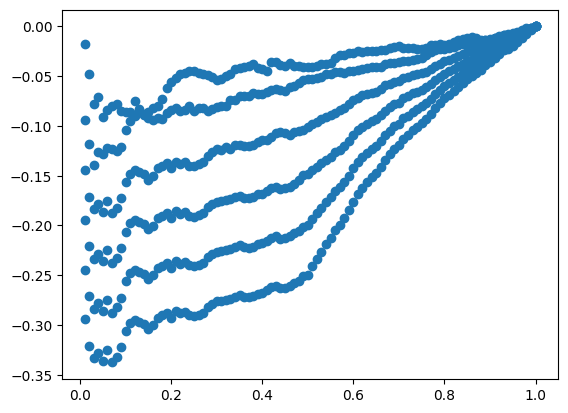

In [19]:
plt.scatter('p', "CVaR", data = mate)

In [25]:
mate.tail()

,p,q,b,CVaR,CVaR_se
0,1.0,0.295392,0.05,5.941830e-19,1.221865e-19
0,1.0,0.345392,0.10,-3.387202e-18,2.012107e-19
0,1.0,0.395392,0.15,3.811579e-19,1.730679e-19
0,1.0,0.445392,0.20,-1.552473e-18,2.315024e-19
0,1.0,0.495392,0.25,1.653062e-20,7.522381e-20


In [28]:
mate_result = pd.read_csv("../data/g1_bbound_mate.csv")
mate_result.tail()

,p,q,b,CVaR,CVaR.se
595,1.0,0.295392,0.05,5.938433e-19,1.221883e-19
596,1.0,0.345392,0.10,-3.388901e-18,2.012172e-19
597,1.0,0.395392,0.15,3.784405e-19,1.730706e-19
598,1.0,0.445392,0.20,-1.552473e-18,2.315058e-19
599,1.0,0.495392,0.25,1.653062e-20,7.522492e-20


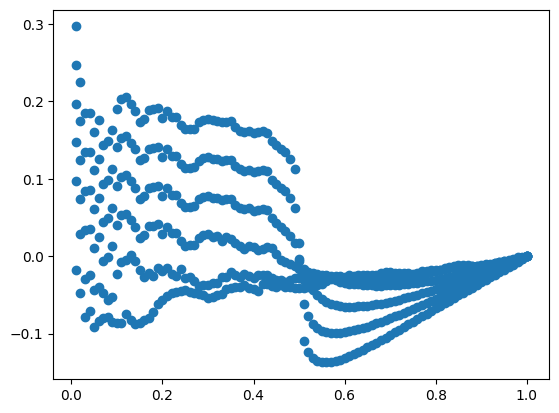

In [29]:
plt.scatter('p', "CVaR", data = mate_result)

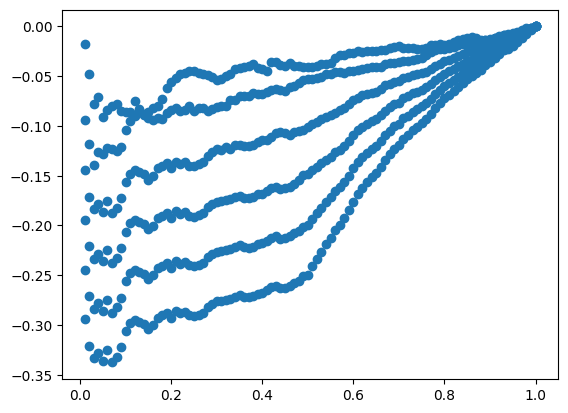

In [34]:
plt.scatter("p", "CVaR", data = mate)

In [61]:
results.head()

,p,b,CVaR,CVaR_se
0,0.01,0.00,-0.028350,0.066771
0,0.01,0.05,-0.130037,0.042954
0,0.01,0.10,-0.179915,0.042955
0,0.01,0.15,-0.229792,0.042957
0,0.01,0.20,-0.279670,0.042961


In [63]:
results.merge(CVaR_bbound_mATE, how='left')

,p,b,CVaR,CVaR_se
0,0.01,0.00,-2.835028e-02,6.677055e-02
1,0.01,0.05,-1.300372e-01,4.295389e-02
2,0.01,0.10,-1.799148e-01,4.295480e-02
3,0.01,0.15,-2.297924e-01,4.295721e-02
4,0.01,0.20,-2.796701e-01,4.296111e-02
...,...,...,...,...
595,1.00,0.00,0.000000e+00,0.000000e+00
596,1.00,0.15,4.300143e-19,1.090299e-19
597,1.00,0.10,-5.323103e-19,7.971671e-20
598,1.00,0.20,5.242965e-21,1.657127e-19


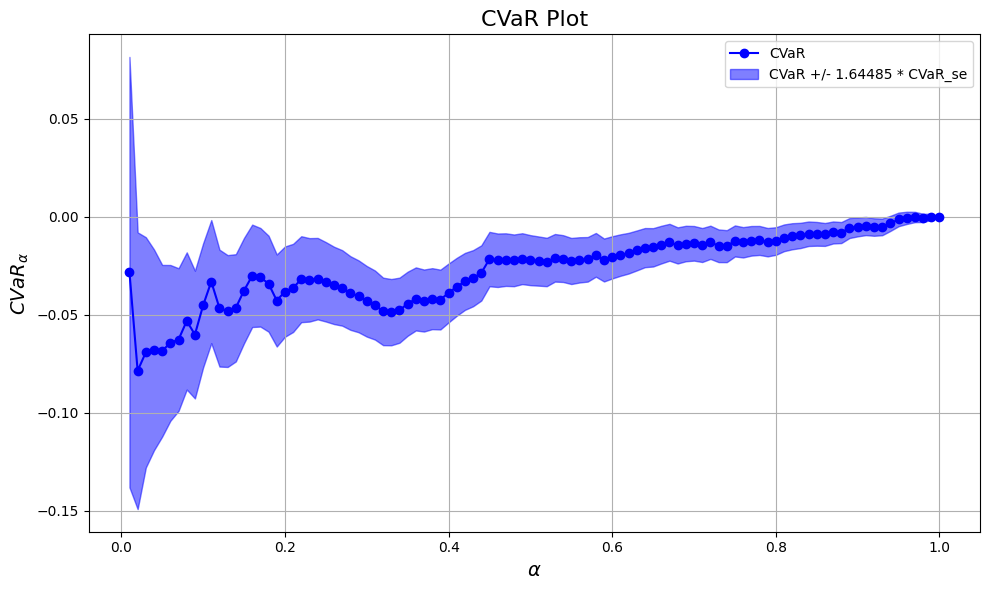

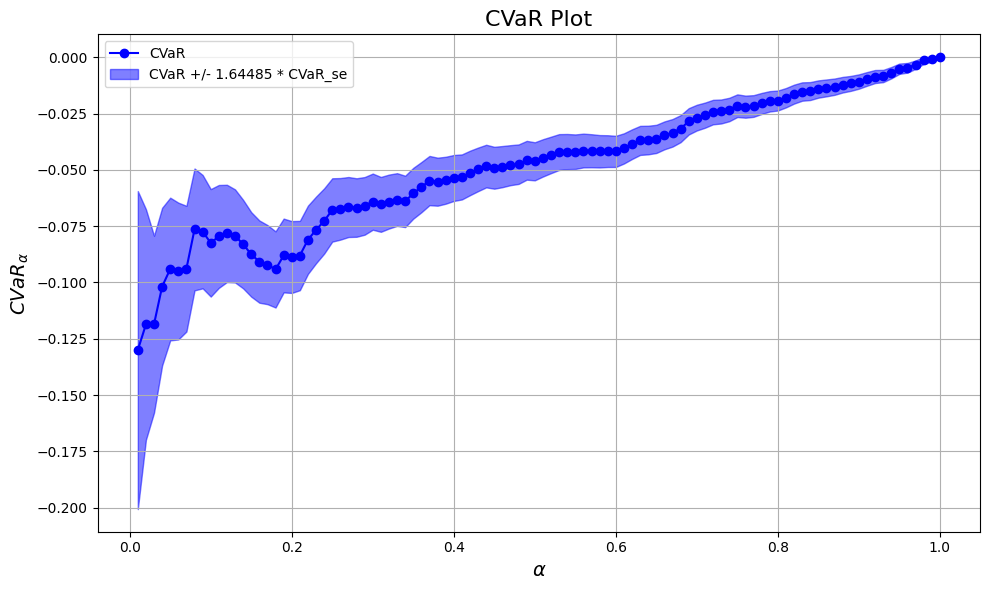

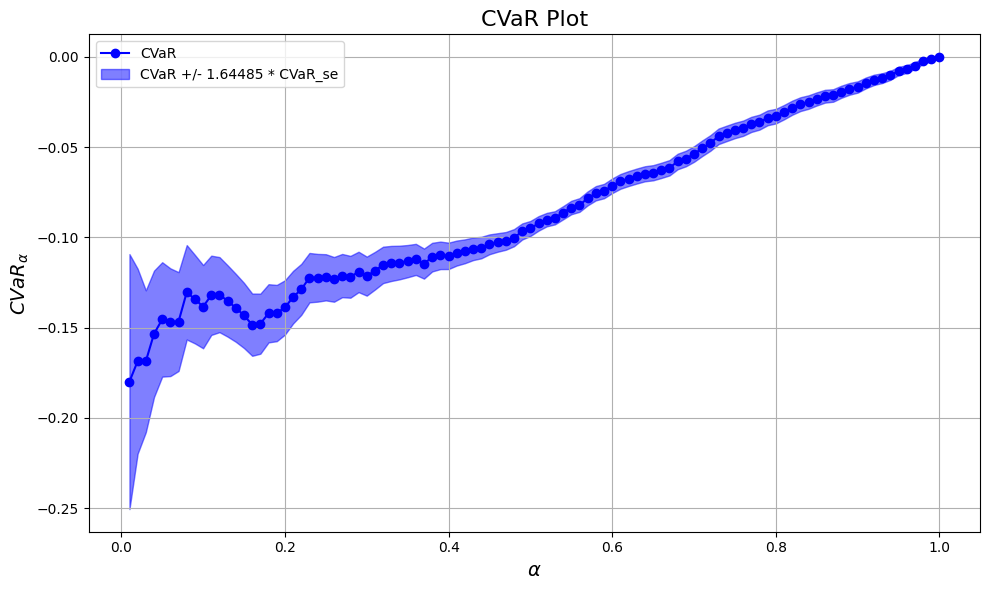

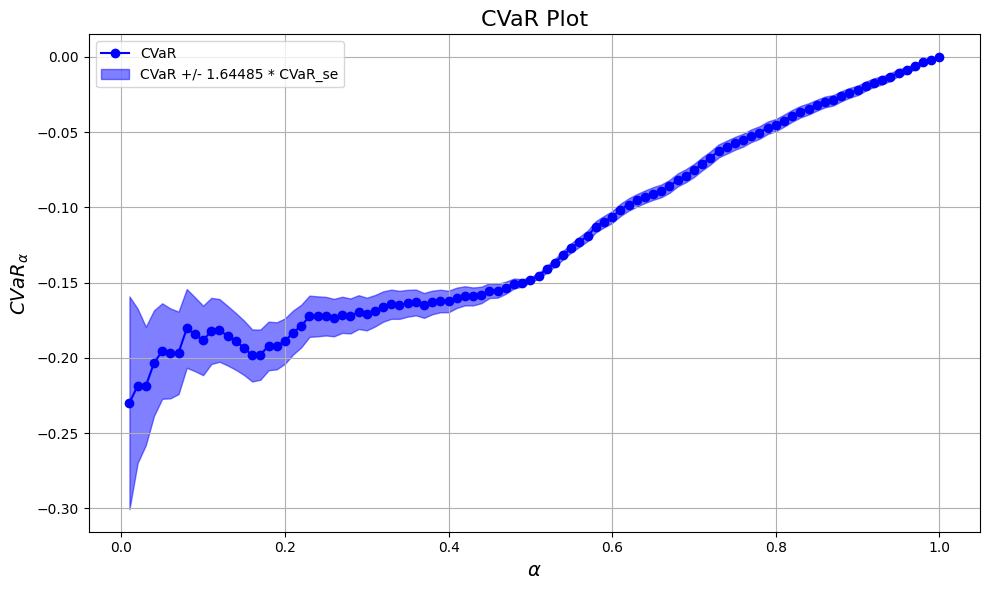

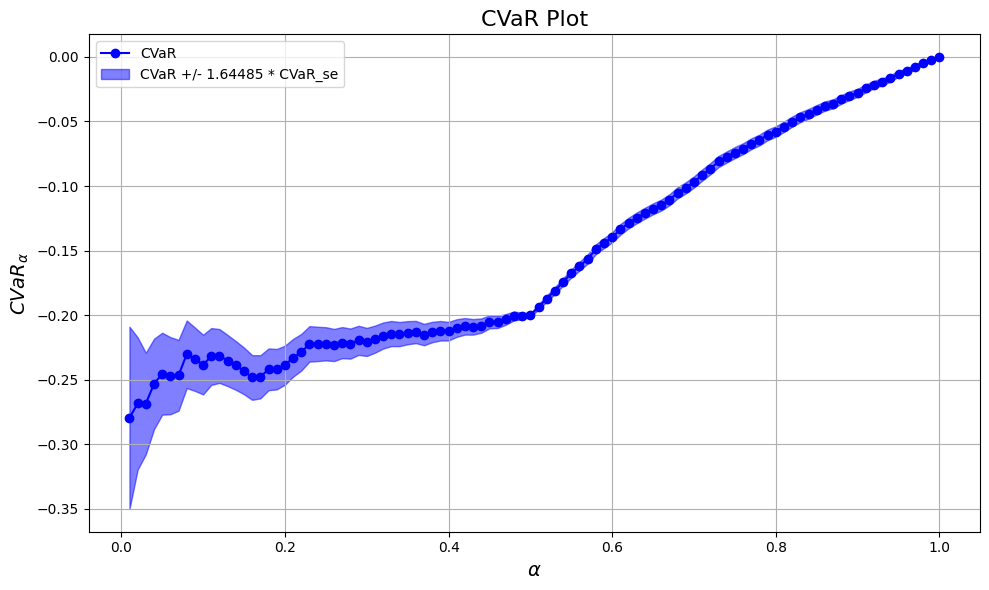

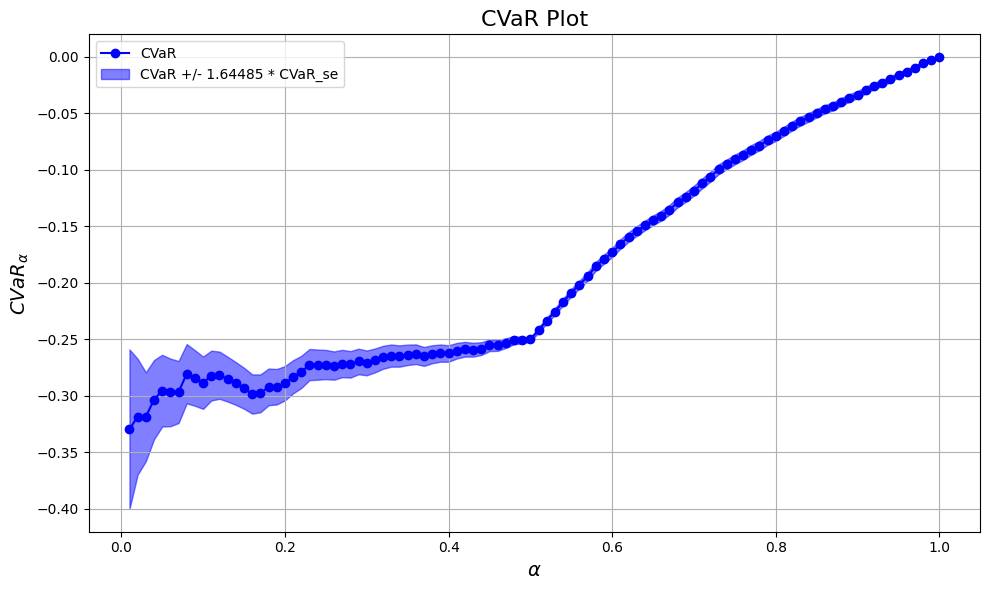

In [50]:
import matplotlib.pyplot as plt

for b in bs:
    ref_df = CVaR_bbound_mATE.query("b == @b")
    plot_cvar(ref_df)
    # plt.scatter('p', 'CVaR', data = ref_df)

In [ ]:
np.sor

In [27]:
job_binary['A'].unique()

array([0, 1])

In [26]:
sw_ipw_y = job_binary['sw'] *  job_binary['Y'] * job_binary['ipw']
a_d = job_binary['A']

a_d1 = sw_ipw_y * a_d
a_d0 = sw_ipw_y * (1 - a_d)
s_n = np.sqrt(len(job_binary))
se1 = np.std(a_d1) / s_n
se0 = np.std(a_d0) / s_n
mu1 = np.mean(a_d1)
mu0 = np.mean(a_d0)


cvte = pd.DataFrame({"p": ps})

cvte['se1']= se1
cvte['se0']= se0
cvte['mu1']= mu1
cvte['mu0']= mu0
cvte


# mu1, se1 = summary.loc[summary['A'] == 1, ['mu', 'se']].values[0]
# mu0, se0 = summary.loc[summary['A'] == 0, ['mu', 'se']].values[0]
# CVaR_TE = pd.DataFrame({'p': ps})
# CVaR_TE['cvar1'] = np.where(CVaR_TE['p'] > 1 - mu1, (mu1 - (1 - CVaR_TE['p'])) / CVaR_TE['p'], 0)
# CVaR_TE['cvar1_se'] = np.where(CVaR_TE['p'] > 1 - mu1, se1 / CVaR_TE['p'], 0)
# CVaR_TE['cvar0'] = np.where(CVaR_TE['p'] > 1 - mu0, (mu0 - (1 - CVaR_TE['p'])) / CVaR_TE['p'], 0)
# CVaR_TE['cvar0_se'] = np.where(CVaR_TE['p'] > 1 - mu0, se0 / CVaR_TE['p'], 0)
# CVaR_TE['cvar_te'] = CVaR_TE['cvar1'] - CVaR_TE['cvar0']
# CVaR_TE['cvar_te_se'] = np.sqrt(CVaR_TE['cvar1_se']**2 + CVaR_TE['cvar0_se']**2)

# job_cvar_te = pd.concat([
#     CVaR_TE.assign(cvar=CVaR_TE['cvar1'], cvar_se=CVaR_TE['cvar1_se'], Group='A=1'),
#     CVaR_TE.assign(cvar=CVaR_TE['cvar0'], cvar_se=CVaR_TE['cvar0_se'], Group='A=0'),
#     CVaR_TE.assign(cvar=CVaR_TE['cvar_te'], cvar_se=CVaR_TE['cvar_te_se'], Group='Diff')
# ])

# job_cvar_te.head()

,p,se1,se0,mu1,mu0
0,0.01,0.00862,0.002259,0.232975,0.189534
1,0.02,0.00862,0.002259,0.232975,0.189534
2,0.03,0.00862,0.002259,0.232975,0.189534
3,0.04,0.00862,0.002259,0.232975,0.189534
4,0.05,0.00862,0.002259,0.232975,0.189534
...,...,...,...,...,...
95,0.96,0.00862,0.002259,0.232975,0.189534
96,0.97,0.00862,0.002259,0.232975,0.189534
97,0.98,0.00862,0.002259,0.232975,0.189534
98,0.99,0.00862,0.002259,0.232975,0.189534
